In [73]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [74]:
class Generator(nn.Module):
    """Image generator
    
    Takes a noise vector as input and syntheses a single channel image accordingly
    """
    #生成器：输入向量，输出对应产生的图像#

    def __init__(self, input_dims, output_dims):
        """Init function
        
        Declare the network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of input noise vector
            output_dims {int} -- Dimension of the output vector (flatten image)
        """
        super(Generator, self).__init__()
        #其中的super类的作用是继承的时候，调用含super的各个的基类__init__函数#
        #如果不使用super，就不会调用这些类的__init__函数，除非显式声明。而且使用super可以避免基类被重复调用。#
        ###  TODO: Change the architecture and value as CW2 Guidance required
        self.fc0 = nn.Sequential(nn.Linear(input_dims, 256), nn.LeakyReLU(0.2))
        self.fc1 = nn.Sequential(nn.Linear(256, 512), nn.LeakyReLU(0.2))
        self.fc2 = nn.Sequential(nn.Linear(512, 1024), nn.LeakyReLU(0.2))
        #nn.Sequential：有序执行，先执行全连接（nn.linear）再执行relu#
        # output hidden layer
        self.fc3 = nn.Sequential(nn.Linear(1024, output_dims), nn.Tanh())
        #输入维度（100）→全连接+leakyrelu→256→全连接+leakyrelu→512→全连接+leakyrelu→1024→全连接+tanh→输出维度（784）#

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of noise vectors in shape (<batch_size>x<input_dims>)
        
        Returns:
            Tensor -- a batch of flatten image in shape (<batch_size>x<output_dims>)
        """
        ###  TODO: modify to be consistent with the network structure
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        #将x输入到上面的两层中，返回输出#



In [75]:
class Discriminator(nn.Module):
    """Image discriminator
    
    Takes a image as input and predict if it is real from the dataset or fake synthesised by the generator
    """
    #判别器：输入图像，判别真假，即是生成器产生的（假）还是数据集里的图像（真）#

    def __init__(self, input_dims, output_dims=1):
        """Init function
        
        Declare the discriminator network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of the flatten input images
            #输入维度为拉成向量后的图像#
        
        Keyword Arguments:
            output_dims {int} -- Predicted probability (default: {1})
            #输出为概率，所以维度默认为1#
        """
        super(Discriminator, self).__init__()

        ###  TODO: Change the architecture and value as CW2 Guidance required
        self.fc0 = nn.Sequential(
            nn.Linear(input_dims, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        #输入维度（784）→全连接层+leakyrelu→1024→全连接层+leakyrelu→512→全连接层+leakyrelu→256→全连接层+sigmoid→概率（1维）#

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of 2D image in shape (<batch_size>xHxW)
        
        Returns:
            Tensor -- predicted probabilities (<batch_size>)
        """
        ###  TODO: modify to be consistent with the network structure

        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    #将x输入到上面的两层中，返回输出#



In [76]:
def show_result(G_net, z_, num_epoch, show=False, save=False, path='result.png'):
    """Result visualisation
    
    Show and save the generated figures in the grid fashion
    
    Arguments:
        G_net {[nn.Module]} -- The generator instant
        z_ {[Tensor]} -- Input noise vectors
        num_epoch {[int]} -- Indicate how many epoch has the generator been trained
    
    Keyword Arguments:
        show {bool} -- If to display the images (default: {False})
        save {bool} -- If to store the images (default: {False})
        path {str} -- path to store the images (default: {'result.png'})
    """

    ###  TODO: complete the rest of part
    # hint: use plt.subplots to construct grid
    # hint: use a 5*5 grid to show all images 
    # hint: use plt.imshow and plt.savefig to display and store the images
    fig,axes=plt.subplots(5,5)
    k=0
    for i in range(5):
        for j in range(5):
                axes[i][j].imshow(G_net(z_).cpu().detach().numpy()[k,:].reshape(28,28),cmap='gray')
                k+=1
    #在每个格子依次显示G（z）的每一行#    
    if save:
        plt.savefig(path)

    if num_epoch in [10,20,50,100]:
        plt.show()
    else:
        plt.close()

In [77]:
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    """Loss tracker
    
    Plot the losses of generator and discriminator independently to see the trend
    
    Arguments:
        hist {[dict]} -- Tracking variables
    
    Keyword Arguments:
        show {bool} -- If to display the figure (default: {False})
        save {bool} -- If to store the figure (default: {False})
        path {str} -- path to store the figure (default: {'Train_hist.png'})
    """
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [78]:
def create_noise(num, dim):
    """Noise constructor
    
    returns a tensor filled with random numbers from a standard normal distribution
    
    Arguments:
        num {int} -- Number of vectors
        dim {int} -- Dimension of vectors
    
    Returns:
        [Tensor] -- the generated noise vector batch
    """
    return torch.randn(num, dim)


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.21it/s]


Epoch 1 of 100 with 21.27 s
Generator loss: 3.15418371, Discriminator loss: 0.93522797


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.34it/s]


Epoch 2 of 100 with 21.17 s
Generator loss: 1.88917907, Discriminator loss: 1.02907141


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.36it/s]


Epoch 3 of 100 with 21.15 s
Generator loss: 1.93689176, Discriminator loss: 1.05389805


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.35it/s]


Epoch 4 of 100 with 21.16 s
Generator loss: 2.34124050, Discriminator loss: 0.75288410


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.40it/s]


Epoch 5 of 100 with 21.13 s
Generator loss: 2.65912253, Discriminator loss: 0.59236095


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.29it/s]


Epoch 6 of 100 with 21.21 s
Generator loss: 3.07917539, Discriminator loss: 0.49695475


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.17it/s]


Epoch 7 of 100 with 21.30 s
Generator loss: 2.59824280, Discriminator loss: 0.57748480


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.39it/s]


Epoch 8 of 100 with 21.13 s
Generator loss: 2.07558760, Discriminator loss: 0.71475836


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.21it/s]


Epoch 9 of 100 with 21.27 s
Generator loss: 2.24027431, Discriminator loss: 0.65850014


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.41it/s]


Epoch 10 of 100 with 21.12 s
Generator loss: 2.11119426, Discriminator loss: 0.71611321


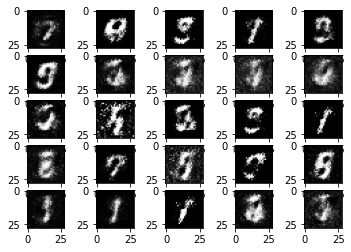

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.42it/s]


Epoch 11 of 100 with 21.11 s
Generator loss: 1.97852593, Discriminator loss: 0.76630883


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.41it/s]


Epoch 12 of 100 with 21.13 s
Generator loss: 1.88993382, Discriminator loss: 0.81240782


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.44it/s]


Epoch 13 of 100 with 21.86 s
Generator loss: 1.91551044, Discriminator loss: 0.78484264


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.32it/s]


Epoch 14 of 100 with 21.19 s
Generator loss: 1.84631141, Discriminator loss: 0.82347170


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.15it/s]


Epoch 15 of 100 with 21.32 s
Generator loss: 1.85871369, Discriminator loss: 0.81092797


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.44it/s]


Epoch 16 of 100 with 21.10 s
Generator loss: 1.76775174, Discriminator loss: 0.85965347


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.46it/s]


Epoch 17 of 100 with 21.08 s
Generator loss: 1.77333200, Discriminator loss: 0.84556060


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.27it/s]


Epoch 18 of 100 with 21.22 s
Generator loss: 1.69022695, Discriminator loss: 0.88711451


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.16it/s]


Epoch 19 of 100 with 21.31 s
Generator loss: 1.65111219, Discriminator loss: 0.90009694


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.18it/s]


Epoch 20 of 100 with 21.29 s
Generator loss: 1.71705687, Discriminator loss: 0.88420451


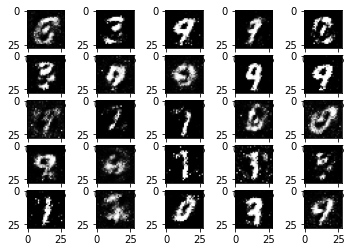

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.46it/s]


Epoch 21 of 100 with 21.08 s
Generator loss: 1.64133886, Discriminator loss: 0.90610974


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.04it/s]


Epoch 22 of 100 with 21.40 s
Generator loss: 1.64150540, Discriminator loss: 0.89374525


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.96it/s]


Epoch 23 of 100 with 22.26 s
Generator loss: 1.61014826, Discriminator loss: 0.92187606


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.28it/s]


Epoch 24 of 100 with 21.22 s
Generator loss: 1.53034782, Discriminator loss: 0.93751526


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.31it/s]


Epoch 25 of 100 with 21.20 s
Generator loss: 1.55416698, Discriminator loss: 0.94065681


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.32it/s]


Epoch 26 of 100 with 21.19 s
Generator loss: 1.56083989, Discriminator loss: 0.94515057


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.42it/s]


Epoch 27 of 100 with 21.11 s
Generator loss: 1.45288444, Discriminator loss: 0.97736669


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.18it/s]


Epoch 28 of 100 with 21.29 s
Generator loss: 1.36512388, Discriminator loss: 1.01980715


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.28it/s]


Epoch 29 of 100 with 21.22 s
Generator loss: 1.43055206, Discriminator loss: 1.00918023


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.42it/s]


Epoch 30 of 100 with 21.11 s
Generator loss: 1.42404371, Discriminator loss: 1.00043553


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.27it/s]


Epoch 31 of 100 with 21.23 s
Generator loss: 1.38863858, Discriminator loss: 1.01220464


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.14it/s]


Epoch 32 of 100 with 21.33 s
Generator loss: 1.43011640, Discriminator loss: 0.98722895


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.42it/s]


Epoch 33 of 100 with 21.12 s
Generator loss: 1.38432424, Discriminator loss: 1.02194927


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.92it/s]


Epoch 34 of 100 with 23.15 s
Generator loss: 1.35777887, Discriminator loss: 1.01491493


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:23<00:00, 26.07it/s]


Epoch 35 of 100 with 23.02 s
Generator loss: 1.30478835, Discriminator loss: 1.04949217


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.12it/s]


Epoch 36 of 100 with 21.34 s
Generator loss: 1.30939207, Discriminator loss: 1.05480998


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.91it/s]


Epoch 37 of 100 with 21.50 s
Generator loss: 1.27324567, Discriminator loss: 1.06746905


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.30it/s]


Epoch 38 of 100 with 21.20 s
Generator loss: 1.28338728, Discriminator loss: 1.06937391


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 39 of 100 with 21.39 s
Generator loss: 1.27964794, Discriminator loss: 1.05801579


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.22it/s]


Epoch 40 of 100 with 21.27 s
Generator loss: 1.23953081, Discriminator loss: 1.07981658


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.24it/s]


Epoch 41 of 100 with 21.25 s
Generator loss: 1.20342915, Discriminator loss: 1.09944666


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 42 of 100 with 21.39 s
Generator loss: 1.19273786, Discriminator loss: 1.11559107


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.14it/s]


Epoch 43 of 100 with 21.32 s
Generator loss: 1.16792950, Discriminator loss: 1.12050620


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.00it/s]


Epoch 44 of 100 with 21.43 s
Generator loss: 1.15878292, Discriminator loss: 1.12932211


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.01it/s]


Epoch 45 of 100 with 21.43 s
Generator loss: 1.17367500, Discriminator loss: 1.11818979


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.07it/s]


Epoch 46 of 100 with 21.37 s
Generator loss: 1.16561211, Discriminator loss: 1.12414584


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 47 of 100 with 21.38 s
Generator loss: 1.13278179, Discriminator loss: 1.13754132


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.98it/s]


Epoch 48 of 100 with 21.44 s
Generator loss: 1.16226755, Discriminator loss: 1.12244728


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.11it/s]


Epoch 49 of 100 with 21.34 s
Generator loss: 1.15898358, Discriminator loss: 1.12632979


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.16it/s]


Epoch 50 of 100 with 22.94 s
Generator loss: 1.12824205, Discriminator loss: 1.14937483


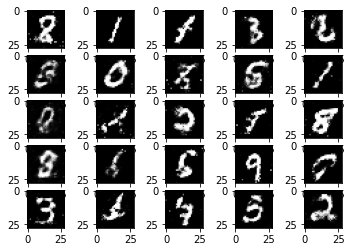

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.84it/s]


Epoch 51 of 100 with 21.55 s
Generator loss: 1.09776288, Discriminator loss: 1.15294236


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.92it/s]


Epoch 52 of 100 with 21.49 s
Generator loss: 1.10728955, Discriminator loss: 1.15642781


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.56it/s]


Epoch 53 of 100 with 21.77 s
Generator loss: 1.09552158, Discriminator loss: 1.16146466


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 27.23it/s]


Epoch 54 of 100 with 22.04 s
Generator loss: 1.06166268, Discriminator loss: 1.17581850


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.72it/s]


Epoch 55 of 100 with 22.46 s
Generator loss: 1.04666417, Discriminator loss: 1.18943456


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.77it/s]


Epoch 56 of 100 with 21.61 s
Generator loss: 1.08314256, Discriminator loss: 1.17382070


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.65it/s]


Epoch 57 of 100 with 21.70 s
Generator loss: 1.08713828, Discriminator loss: 1.16888651


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 58 of 100 with 21.38 s
Generator loss: 1.05937766, Discriminator loss: 1.18018990


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.18it/s]


Epoch 59 of 100 with 21.29 s
Generator loss: 1.03429214, Discriminator loss: 1.19120565


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.01it/s]


Epoch 60 of 100 with 21.42 s
Generator loss: 1.05196331, Discriminator loss: 1.18796221


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.04it/s]


Epoch 61 of 100 with 21.40 s
Generator loss: 1.03391976, Discriminator loss: 1.19178850


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.19it/s]


Epoch 62 of 100 with 21.28 s
Generator loss: 1.02487140, Discriminator loss: 1.20402735


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.70it/s]


Epoch 63 of 100 with 21.66 s
Generator loss: 1.05239557, Discriminator loss: 1.20045709


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.16it/s]


Epoch 64 of 100 with 21.31 s
Generator loss: 1.07522040, Discriminator loss: 1.17572452


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.18it/s]


Epoch 65 of 100 with 21.30 s
Generator loss: 1.04619189, Discriminator loss: 1.18661197


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.17it/s]


Epoch 66 of 100 with 21.30 s
Generator loss: 0.99836965, Discriminator loss: 1.21157099


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.02it/s]


Epoch 67 of 100 with 21.41 s
Generator loss: 1.01397014, Discriminator loss: 1.20645683


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.66it/s]


Epoch 68 of 100 with 21.69 s
Generator loss: 1.01374305, Discriminator loss: 1.21343262


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.56it/s]


Epoch 69 of 100 with 21.77 s
Generator loss: 0.99779590, Discriminator loss: 1.21328582


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.16it/s]


Epoch 70 of 100 with 21.31 s
Generator loss: 1.00178999, Discriminator loss: 1.21315710


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.15it/s]


Epoch 71 of 100 with 21.32 s
Generator loss: 1.00965165, Discriminator loss: 1.20849659


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.19it/s]


Epoch 72 of 100 with 21.28 s
Generator loss: 1.02665708, Discriminator loss: 1.20485823


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.17it/s]


Epoch 73 of 100 with 21.30 s
Generator loss: 0.99154343, Discriminator loss: 1.21990043


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.11it/s]


Epoch 74 of 100 with 21.35 s
Generator loss: 1.00054964, Discriminator loss: 1.22140958


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.80it/s]


Epoch 75 of 100 with 21.59 s
Generator loss: 0.98439563, Discriminator loss: 1.22454451


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.01it/s]


Epoch 76 of 100 with 21.43 s
Generator loss: 0.98127116, Discriminator loss: 1.23192353


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.14it/s]


Epoch 77 of 100 with 21.32 s
Generator loss: 0.97848057, Discriminator loss: 1.22621450


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.13it/s]


Epoch 78 of 100 with 21.33 s
Generator loss: 0.97025630, Discriminator loss: 1.23274013


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 79 of 100 with 21.38 s
Generator loss: 0.98447459, Discriminator loss: 1.22247752


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.94it/s]


Epoch 80 of 100 with 21.47 s
Generator loss: 0.99397682, Discriminator loss: 1.22038623


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.15it/s]


Epoch 81 of 100 with 21.32 s
Generator loss: 0.99491603, Discriminator loss: 1.21796559


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.11it/s]


Epoch 82 of 100 with 21.35 s
Generator loss: 0.96390562, Discriminator loss: 1.24073902


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.93it/s]


Epoch 83 of 100 with 21.48 s
Generator loss: 0.96971702, Discriminator loss: 1.23182184


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.07it/s]


Epoch 84 of 100 with 21.38 s
Generator loss: 0.98963130, Discriminator loss: 1.22985088


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.91it/s]


Epoch 85 of 100 with 21.50 s
Generator loss: 0.98132938, Discriminator loss: 1.22512560


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.35it/s]


Epoch 86 of 100 with 21.94 s
Generator loss: 0.97709660, Discriminator loss: 1.23100911


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.73it/s]


Epoch 87 of 100 with 22.45 s
Generator loss: 0.96901034, Discriminator loss: 1.23844615


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.17it/s]


Epoch 88 of 100 with 22.93 s
Generator loss: 0.93898756, Discriminator loss: 1.24165005


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 27.17it/s]


Epoch 89 of 100 with 22.09 s
Generator loss: 0.95703657, Discriminator loss: 1.24636277


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.93it/s]


Epoch 90 of 100 with 21.48 s
Generator loss: 0.95979719, Discriminator loss: 1.23560128


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.95it/s]


Epoch 91 of 100 with 21.47 s
Generator loss: 0.93680963, Discriminator loss: 1.24897014


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.02it/s]


Epoch 92 of 100 with 21.41 s
Generator loss: 0.96024300, Discriminator loss: 1.23793585


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.06it/s]


Epoch 93 of 100 with 21.38 s
Generator loss: 0.94895727, Discriminator loss: 1.24355584


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.88it/s]


Epoch 94 of 100 with 21.52 s
Generator loss: 0.97169658, Discriminator loss: 1.23820163


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.92it/s]


Epoch 95 of 100 with 21.49 s
Generator loss: 0.96710700, Discriminator loss: 1.24229386


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.00it/s]


Epoch 96 of 100 with 21.43 s
Generator loss: 0.97037852, Discriminator loss: 1.23302775


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.00it/s]


Epoch 97 of 100 with 21.43 s
Generator loss: 0.95077126, Discriminator loss: 1.24523191


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.85it/s]


Epoch 98 of 100 with 21.54 s
Generator loss: 0.94250342, Discriminator loss: 1.25196042


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.93it/s]


Epoch 99 of 100 with 21.49 s
Generator loss: 0.94278952, Discriminator loss: 1.24711922


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 28.07it/s]


Epoch 100 of 100 with 21.38 s
Generator loss: 0.94433404, Discriminator loss: 1.25189549


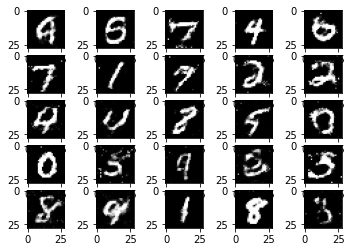

Avg per epoch ptime: 21.47, total 100 epochs ptime: 2241.48
Training finish!... save training results


In [79]:
if __name__ == '__main__':
    #if __name__ == '__main__'意思是如果用该文件直接执行，会运行下面的代码，当该文件被调用时，不执行下面的代码#
    #也就是说当该文件被调用，只调用前面定义的一大堆函数，接下来的主程序不执行#
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_GAN_results/'
    image_save_dir = './MNIST_GAN_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 100
    learning_rate = 0.0002
    epochs = 100

    # parameters for Models
    image_size = 28
    G_input_dim = 100
    G_output_dim = image_size * image_size
    D_input_dim = image_size * image_size
    D_output_dim = 1

    # construct the dataset and data loader
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5,), std=(0.5,))])
    #定义转换器，将图片转化为张量#
    train_data = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
    #利用上面的转换器将数据集转换#
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    #载入上面转换后的图片#

    # declare the generator and discriminator networks    
    G_net = Generator(G_input_dim, G_output_dim).to(device)
    D_net = Discriminator(D_input_dim, D_output_dim).to(device)
    #使用上面定义的生成器和判别器网络#

    # Binary Cross Entropy Loss function
    criterion = nn.BCELoss().to(device)
    #定义损失函数#

    # Initialise the Optimizers
    G_optimizer = torch.optim.Adam(G_net.parameters(), lr=learning_rate)
    D_optimizer = torch.optim.Adam(D_net.parameters(), lr=learning_rate)
    #定义优化器#
    

    # tracking variables
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['per_epoch_ptimes'] = []
    train_hist['total_ptime'] = []

    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        G_net.train()
        D_net.train()
        Loss_G = []
        Loss_D = []
        epoch_start_time = time.time()
        for (image, _) in tqdm(train_loader):
            image = image.to(device)
            b_size = len(image)
            # creat real and fake labels
            real_label = torch.ones(b_size, 1).to(device)
            fake_label = torch.zeros(b_size, 1).to(device)

            # generate fake images 
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))
            data_real = image.view(b_size, D_input_dim)

            # --------train the discriminator network----------
            # compute the loss for real and fake images
            output_real = D_net(data_real)
            output_fake = D_net(data_fake)
            loss_real = criterion(output_real, real_label)
            loss_fake = criterion(output_fake, fake_label)
            loss_d = loss_real + loss_fake

            # back propagation
            D_optimizer.zero_grad()
            loss_d.backward()
            D_optimizer.step()

            # -------- train the generator network-----------
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))

            # compute the loss for generator network
            output_fake = D_net(data_fake)
            loss_g = criterion(output_fake, real_label)

            ## back propagation
            G_optimizer.zero_grad()
            loss_g.backward()
            G_optimizer.step()

            ## store the loss of each iter
            Loss_D.append(loss_d.item())
            Loss_G.append(loss_g.item())

        epoch_loss_g = np.mean(Loss_G)  # mean generator loss for the epoch
        epoch_loss_d = np.mean(Loss_D)  # mean discriminator loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Generator loss: %.8f, Discriminator loss: %.8f" % (epoch_loss_g, epoch_loss_d))

        path = image_save_dir + '/MNIST_GAN_' + str(epoch + 1) + '.png'
        show_result(G_net, create_noise(25, 100).to(device), (epoch + 1), save=True, path=path)
        #输入25个维度为100的向量，输出25个28*28的图片#

        # record the loss for every epoch
        train_hist['G_losses'].append(epoch_loss_g)
        train_hist['D_losses'].append(epoch_loss_d)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))
    print("Training finish!... save training results")
    with open(save_dir + '/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)
    show_train_hist(train_hist, save=True, path=save_dir + '/MNIST_GAN_train_hist.png')